# Warehouse Organization for MAPD

Optimalizace rozložení skladu pomocí Multi-Agent Pickup and Delivery (MAPD) s využitím surrogate modelů.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from IPython.display import HTML

from warehouse import Warehouse, OrderGenerator
from mapd_solver import MAPDSimulator, AgentState

## 1. Warehouse a OrderGenerator

### 1.1 Vytvoření skladu

In [36]:
# Vytvoření skladu 7x7
warehouse = Warehouse(7, 7)
print(f"Warehouse: {warehouse}")
print(f"Počet vnitřních pozic (zboží): {warehouse.n_inner}")
print(f"Počet delivery points: {len(warehouse.get_delivery_points())}")

Warehouse: Warehouse(7x7, 25 goods)
Počet vnitřních pozic (zboží): 25
Počet delivery points: 24


In [37]:
# Nastavení náhodného rozložení zboží
np.random.seed(42)
layout = list(range(warehouse.n_inner))
np.random.shuffle(layout)
warehouse.set_layout(layout)

print(f"Layout (permutace): {layout}")
print(f"Zboží 0 je na pozici: {warehouse.get_goods_position(0)}")
print(f"Zboží 24 je na pozici: {warehouse.get_goods_position(24)}")

Layout (permutace): [8, 16, 0, 23, 11, 9, 13, 1, 22, 5, 2, 12, 15, 3, 4, 20, 17, 21, 18, 24, 7, 10, 14, 19, 6]
Zboží 0 je na pozici: (3, 1)
Zboží 24 je na pozici: (5, 4)


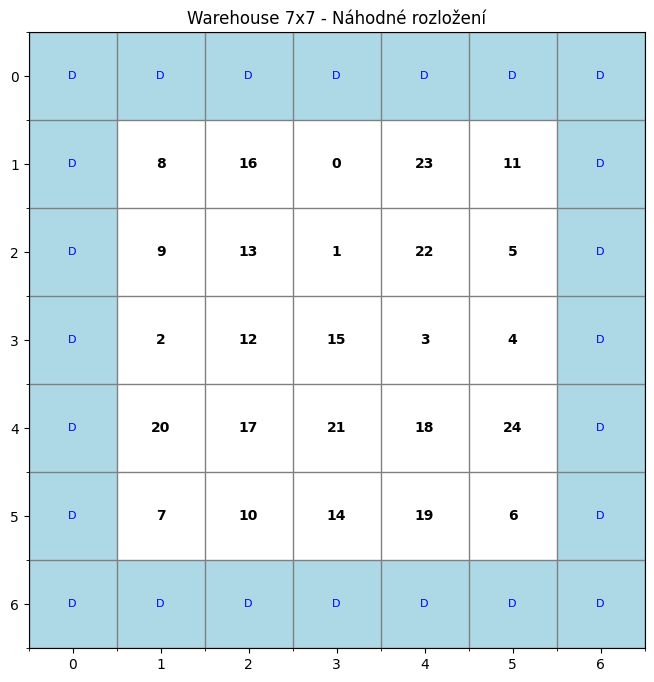

In [38]:
def visualize_warehouse(warehouse, title="Warehouse Layout", ax=None):
    """Vizualizace skladu s rozložením zboží."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Vytvoření gridu
    grid = np.zeros((warehouse.height, warehouse.width))
    
    # Označení delivery points (okraj)
    for x, y in warehouse.get_delivery_points():
        grid[y, x] = -1  # Delivery point
    
    # Zobrazení gridu
    cmap = ListedColormap(['lightblue', 'white'])
    ax.imshow(grid, cmap=cmap, vmin=-1, vmax=0)
    
    # Přidání čísel zboží do vnitřních buněk
    if warehouse.layout is not None:
        for idx, (x, y) in enumerate(warehouse.get_inner_positions()):
            goods_id = warehouse.layout[idx]
            ax.text(x, y, str(goods_id), ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Označení delivery points
    for x, y in warehouse.get_delivery_points():
        ax.text(x, y, 'D', ha='center', va='center', fontsize=8, color='blue')
    
    # Grid lines
    ax.set_xticks(np.arange(-0.5, warehouse.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, warehouse.height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
    ax.set_xticks(range(warehouse.width))
    ax.set_yticks(range(warehouse.height))
    ax.set_title(title)
    
    return ax

visualize_warehouse(warehouse, "Warehouse 7x7 - Náhodné rozložení")
plt.show()

### 1.2 Order Generator - Zipf distribuce

In [39]:
# Vytvoření generátoru objednávek
order_gen = OrderGenerator(warehouse.n_inner, distribution="zipf", zipf_param=1.5, seed=42)
print(f"Order Generator: {order_gen}")
print(f"\nPravděpodobnosti (první 10 položek):")
for i, p in enumerate(order_gen.get_probabilities()[:10]):
    print(f"  Zboží {i}: {p:.4f} ({p*100:.1f}%)")

Order Generator: OrderGenerator(25 goods, zipf)

Pravděpodobnosti (první 10 položek):
  Zboží 0: 0.4512 (45.1%)
  Zboží 1: 0.1595 (16.0%)
  Zboží 2: 0.0868 (8.7%)
  Zboží 3: 0.0564 (5.6%)
  Zboží 4: 0.0404 (4.0%)
  Zboží 5: 0.0307 (3.1%)
  Zboží 6: 0.0244 (2.4%)
  Zboží 7: 0.0199 (2.0%)
  Zboží 8: 0.0167 (1.7%)
  Zboží 9: 0.0143 (1.4%)


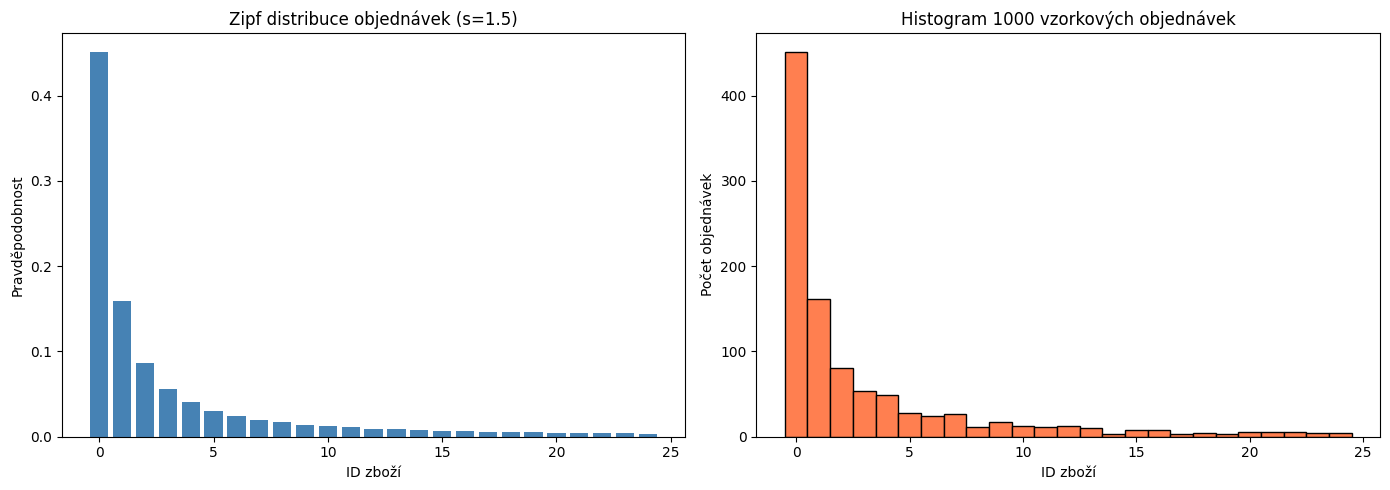

In [40]:
# Vizualizace distribuce objednávek
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuce pravděpodobností
probs = order_gen.get_probabilities()
axes[0].bar(range(len(probs)), probs, color='steelblue')
axes[0].set_xlabel('ID zboží')
axes[0].set_ylabel('Pravděpodobnost')
axes[0].set_title('Zipf distribuce objednávek (s=1.5)')

# Histogram vzorku objednávek
sample_orders = order_gen.generate_orders(1000)
axes[1].hist(sample_orders, bins=range(warehouse.n_inner + 1), color='coral', edgecolor='black', align='left')
axes[1].set_xlabel('ID zboží')
axes[1].set_ylabel('Počet objednávek')
axes[1].set_title('Histogram 1000 vzorkových objednávek')

plt.tight_layout()
plt.show()

In [41]:
# Test Poisson generování
print("Poisson generování objednávek (lambda=0.5):")
for i in range(10):
    orders = order_gen.generate_poisson_orders(0.5)
    print(f"  Timestep {i}: {len(orders)} objednávek - {orders}")

Poisson generování objednávek (lambda=0.5):
  Timestep 0: 0 objednávek - []
  Timestep 1: 0 objednávek - []
  Timestep 2: 0 objednávek - []
  Timestep 3: 0 objednávek - []
  Timestep 4: 1 objednávek - [np.int64(11)]
  Timestep 5: 0 objednávek - []
  Timestep 6: 1 objednávek - [np.int64(2)]
  Timestep 7: 0 objednávek - []
  Timestep 8: 0 objednávek - []
  Timestep 9: 1 objednávek - [np.int64(0)]


## 2. MAPD Simulace

### 2.1 Test SAT Path Planneru

In [42]:
from mapd_solver import SATPathPlanner

# Test jednoduchého path planningu
planner = SATPathPlanner(warehouse)

start = (0, 0)  # Delivery point
goal = (3, 3)   # Vnitřní buňka

path = planner.plan_path(start, goal, frozen_paths={})
print(f"Cesta z {start} do {goal}:")
print(f"  {path}")
print(f"  Délka: {len(path)} kroků")

Cesta z (0, 0) do (3, 3):
  [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3)]
  Délka: 7 kroků


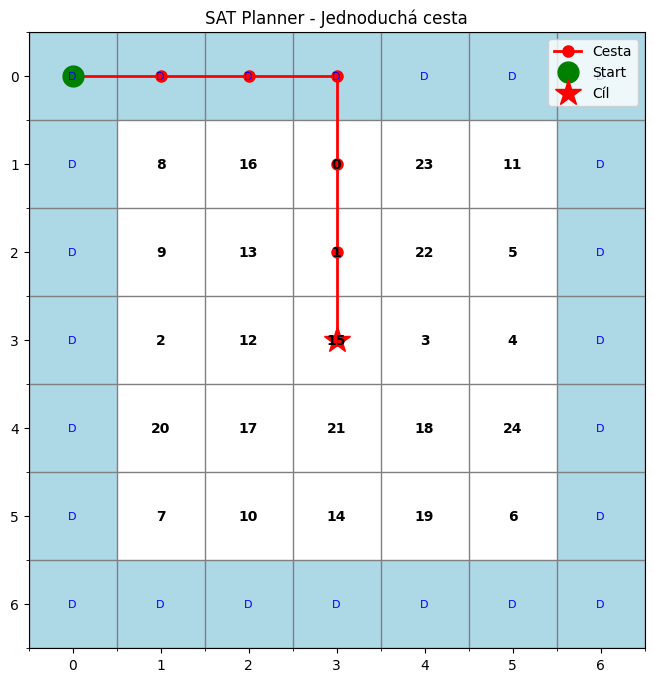

In [43]:
def visualize_path(warehouse, path, title="Path"):
    """Vizualizace cesty agenta."""
    fig, ax = plt.subplots(figsize=(8, 8))
    visualize_warehouse(warehouse, title, ax)
    
    if path:
        # Vykreslení cesty
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        ax.plot(xs, ys, 'r-', linewidth=2, marker='o', markersize=8, label='Cesta')
        
        # Označení startu a cíle
        ax.plot(xs[0], ys[0], 'go', markersize=15, label='Start')
        ax.plot(xs[-1], ys[-1], 'r*', markersize=20, label='Cíl')
        ax.legend()
    
    plt.show()

visualize_path(warehouse, path, "SAT Planner - Jednoduchá cesta")

In [44]:
# Test s frozen paths (překážky)
frozen_paths = {
    0: [(1, 1), (2, 1), (3, 1), (3, 2), (3, 3)]  # Agent 0 jde zleva
}

start2 = (0, 3)
goal2 = (3, 1)

path2 = planner.plan_path(start2, goal2, frozen_paths=frozen_paths)
print(f"Cesta z {start2} do {goal2} s překážkou:")
print(f"  {path2}")

Cesta z (0, 3) do (3, 1) s překážkou:
  [(0, 3), (1, 3), (2, 3), (2, 2), (2, 1), (3, 1)]


### 2.2 MAPD Simulace - Základní běh

In [45]:
# Vytvoření simulátoru
sim = MAPDSimulator(warehouse, n_agents=3, order_generator=order_gen, seed=42)

print("Počáteční stav:")
state = sim.get_state()
print(f"  Čas: {state['time']}")
print(f"  Agenti: {state['agents']}")
print(f"  Dokončené objednávky: {state['completed_orders']}")

Počáteční stav:
  Čas: 0
  Agenti: [(0, (6, 1), 'idle', None), (1, (0, 6), 'idle', None), (2, (6, 2), 'idle', None)]
  Dokončené objednávky: 0


In [46]:
# Spuštění simulace
throughput = sim.run(n_steps=20, order_lambda=0.3)

print(f"\nPo 200 krocích:")
print(f"  Propustnost: {throughput:.4f} objednávek/krok")
print(f"  Dokončené objednávky: {sim.completed_orders}")
print(f"  Čekající objednávky: {len(sim.pending_orders)}")


Po 200 krocích:
  Propustnost: 0.2000 objednávek/krok
  Dokončené objednávky: 4
  Čekající objednávky: 0


### 2.3 Animace simulace

In [47]:
def run_simulation_with_history(warehouse, n_agents, order_gen, n_steps, order_lambda, seed=42):
    """Spustí simulaci a vrátí historii stavů pro animaci."""
    sim = MAPDSimulator(warehouse, n_agents=n_agents, order_generator=order_gen, seed=seed)
    history = [sim.get_state()]
    
    for _ in range(n_steps):
        new_orders = order_gen.generate_poisson_orders(order_lambda)
        sim.add_orders(new_orders)
        sim.step()
        history.append(sim.get_state())
    
    return history, sim

# Spuštění krátké simulace pro animaci
history, sim = run_simulation_with_history(warehouse, n_agents=3, order_gen=order_gen, 
                                            n_steps=50, order_lambda=0.3, seed=123)
print(f"Zaznamenáno {len(history)} stavů")

Zaznamenáno 51 stavů


In [48]:
def create_animation(warehouse, history, interval=200):
    """Vytvoří animaci simulace."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Barvy pro agenty
    agent_colors = ['red', 'green', 'blue', 'orange', 'purple']
    
    def init():
        ax.clear()
        return []
    
    def animate(frame):
        ax.clear()
        state = history[frame]
        
        # Vykreslení skladu
        grid = np.zeros((warehouse.height, warehouse.width))
        for x, y in warehouse.get_delivery_points():
            grid[y, x] = -1
        
        cmap = ListedColormap(['lightblue', 'white'])
        ax.imshow(grid, cmap=cmap, vmin=-1, vmax=0)
        
        # Čísla zboží
        if warehouse.layout is not None:
            for idx, (x, y) in enumerate(warehouse.get_inner_positions()):
                goods_id = warehouse.layout[idx]
                ax.text(x, y, str(goods_id), ha='center', va='center', fontsize=8, alpha=0.5)
        
        # Delivery points
        for x, y in warehouse.get_delivery_points():
            ax.text(x, y, 'D', ha='center', va='center', fontsize=6, color='blue', alpha=0.5)
        
        # Agenti
        for agent_id, pos, agent_state, carrying in state['agents']:
            color = agent_colors[agent_id % len(agent_colors)]
            marker = 's' if carrying is not None else 'o'  # Čtverec pokud nese zboží
            ax.plot(pos[0], pos[1], marker, color=color, markersize=20, 
                   label=f'Agent {agent_id} ({agent_state})')
            ax.text(pos[0], pos[1], str(agent_id), ha='center', va='center', 
                   fontsize=10, fontweight='bold', color='white')
        
        # Grid lines
        ax.set_xticks(np.arange(-0.5, warehouse.width, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, warehouse.height, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
        ax.set_xticks(range(warehouse.width))
        ax.set_yticks(range(warehouse.height))
        
        ax.set_title(f"t={state['time']} | Dokončeno: {state['completed_orders']} | Čeká: {state['pending_orders']}")
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
        return []
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                   frames=len(history), interval=interval, blit=True)
    plt.close()
    return anim

# Vytvoření animace
anim = create_animation(warehouse, history, interval=300)
HTML(anim.to_jshtml())

### 2.4 Měření propustnosti pro různé konfigurace

In [49]:
def measure_throughput(warehouse, n_agents, order_gen, n_steps=500, order_lambda=0.5, n_runs=5):
    """Měří průměrnou propustnost přes několik běhů."""
    throughputs = []
    for run in range(n_runs):
        sim = MAPDSimulator(warehouse, n_agents=n_agents, order_generator=order_gen, seed=run*100)
        tp = sim.run(n_steps=n_steps, order_lambda=order_lambda)
        throughputs.append(tp)
    return np.mean(throughputs), np.std(throughputs)

## 3. Surrogate modely

### 3.1 Sběr trénovacích dat

In [50]:
from surrogate import extract_features, SurrogateModel, compare_models
from evolution import collect_initial_data

# Sběr trénovacích dat (50 náhodných rozložení)
# Používáme 1 agenta pro rychlost - SAT solver je s více agenty pomalý
print("Sbírám trénovací data (50 náhodných rozložení, 1 agent)...")

features_list, fitness_list, layouts_list = collect_initial_data(
    warehouse, order_gen, 
    n_agents=1,   
    n_samples=50,
    sim_steps=100, 
    order_lambda=0.3,
    seed=42,
    verbose=True
)

X_train = np.array(features_list)
y_train = np.array(fitness_list)

print(f"\nSebrána data: {X_train.shape[0]} vzorků, {X_train.shape[1]} features")
print(f"Throughput range: [{y_train.min():.4f}, {y_train.max():.4f}]")

Sbírám trénovací data (50 náhodných rozložení, 1 agent)...
  Collected 10/50 samples
  Collected 20/50 samples
  Collected 30/50 samples
  Collected 40/50 samples
  Collected 50/50 samples

Sebrána data: 50 vzorků, 6 features
Throughput range: [0.1400, 0.2700]


/var/folders/lw/rrnr4xkd00566t_gbf03x09c0000gn/T/ipykernel_81030/4265439736.py:15: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(X_train[:, i], y_train, 1)
/var/folders/lw/rrnr4xkd00566t_gbf03x09c0000gn/T/ipykernel_81030/4265439736.py:15: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(X_train[:, i], y_train, 1)


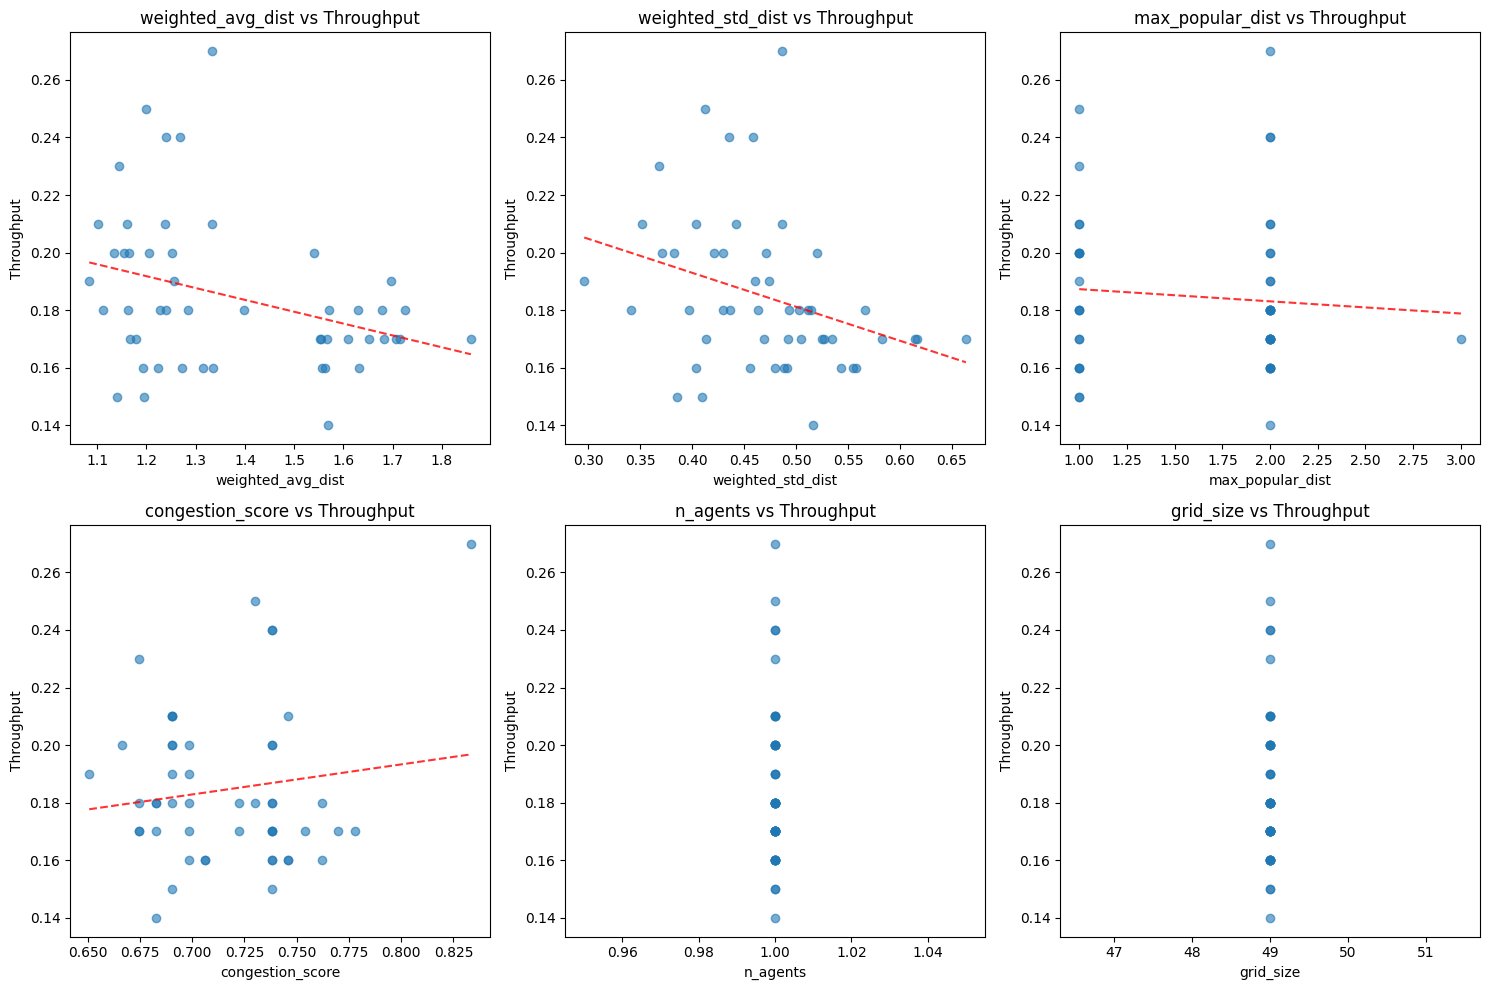

In [51]:
# Vizualizace features vs. fitness
feature_names = ['weighted_avg_dist', 'weighted_std_dist', 'max_popular_dist', 
                 'congestion_score', 'n_agents', 'grid_size']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (ax, name) in enumerate(zip(axes, feature_names)):
    ax.scatter(X_train[:, i], y_train, alpha=0.6)
    ax.set_xlabel(name)
    ax.set_ylabel('Throughput')
    ax.set_title(f'{name} vs Throughput')
    
    # Fit line
    z = np.polyfit(X_train[:, i], y_train, 1)
    p = np.poly1d(z)
    x_line = np.linspace(X_train[:, i].min(), X_train[:, i].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8)

plt.tight_layout()
plt.show()

### 3.2 Porovnání surrogate modelů

Porovnání modelů (5-fold CV):

  linear    : R² = 0.085 ± 0.183
  gp        : R² = 0.029 ± 0.161
  rf        : R² = -0.390 ± 0.367


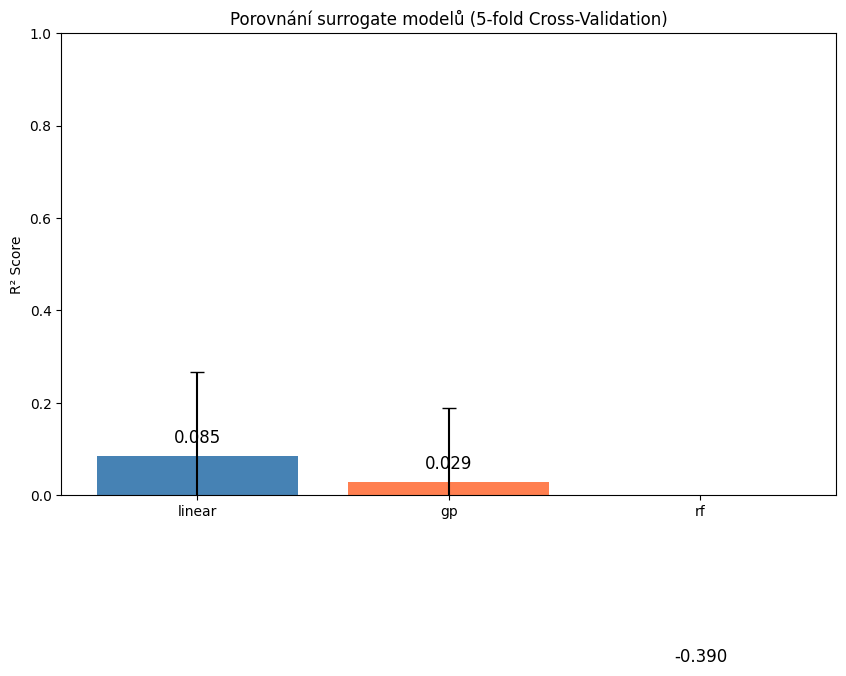

In [52]:
# Cross-validation porovnání modelů
print("Porovnání modelů (5-fold CV):\n")
results = compare_models(X_train, y_train, cv=5)

for name, scores in results.items():
    print(f"  {name:10s}: R² = {scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}")

# Vizualizace
model_names = list(results.keys())
r2_means = [results[m]['r2_mean'] for m in model_names]
r2_stds = [results[m]['r2_std'] for m in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_means, yerr=r2_stds, capsize=5, color=['steelblue', 'coral', 'green', 'purple'][:len(model_names)])
plt.ylabel('R² Score')
plt.title('Porovnání surrogate modelů (5-fold Cross-Validation)')
plt.ylim(0, 1)
for bar, mean in zip(bars, r2_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{mean:.3f}', 
             ha='center', va='bottom', fontsize=12)
plt.show()

## 4. Evoluční optimalizace

### 4.1 Baseline metody

In [53]:
from baselines import run_all_baselines

# Spuštění baseline metod (1 agent pro rychlost)
print("Spouštím baseline metody (1 agent)...")
baseline_results = run_all_baselines(
    warehouse, order_gen, 
    n_agents=1,          # 1 agent = rychlejší
    random_samples=30,   # Méně vzorků
    sim_steps=200,
    order_lambda=0.3,
    seed=42,
    verbose=True
)

print("\n" + "=" * 50)
print("Baseline výsledky:")
print("=" * 50)
print(f"Random:         best={baseline_results['random']['best_fitness']:.4f}, "
      f"mean={baseline_results['random']['mean_fitness']:.4f} ± {baseline_results['random']['std_fitness']:.4f}")
print(f"Greedy:         {baseline_results['greedy']['fitness']:.4f}")
print(f"Inverse Greedy: {baseline_results['inverse_greedy']['fitness']:.4f}")

Spouštím baseline metody (1 agent)...
Running baselines...

1. Random baseline:
  Random: 20/30 samples, best so far: 0.2250

2. Greedy baseline:
  Greedy fitness: 0.1950

3. Inverse greedy baseline:
  Inverse greedy fitness: 0.1650

Baseline výsledky:
Random:         best=0.2400, mean=0.1845 ± 0.0195
Greedy:         0.1950
Inverse Greedy: 0.1650


### 4.2 Evoluce BEZ surrogate (pure EA)

In [54]:
from evolution import run_evolution

# Evoluce bez surrogate (1 agent pro rychlost)
print("Spouštím evoluci BEZ surrogate (1 agent)...")

ea_no_surrogate = run_evolution(
    warehouse, order_gen, 
    n_agents=1,          # 1 agent = rychlejší
    n_generations=50,
    pop_size=20,
    use_surrogate=False,
    sim_steps=150,
    order_lambda=0.3,
    seed=42,
    verbose=True
)

print(f"\nVýsledky (bez surrogate):")
print(f"  Best fitness: {ea_no_surrogate['best_fitness']:.4f}")
print(f"  Real evaluations: {ea_no_surrogate['real_evals']}")
print(f"  Wall time: {ea_no_surrogate['wall_time']:.1f}s")

Spouštím evoluci BEZ surrogate (1 agent)...
Gen 0: best=0.2333, avg=0.1820, std=0.0190
Gen 10: best=0.2267, avg=0.1870
Gen 20: best=0.2533, avg=0.2080
Gen 30: best=0.2800, avg=0.2140
Gen 40: best=0.2467, avg=0.2167
Gen 50: best=0.2600, avg=0.2120

Výsledky (bez surrogate):
  Best fitness: 0.2800
  Real evaluations: 1020
  Wall time: 133.4s


### 4.3 Evoluce SE surrogate

In [55]:
# Evoluce s surrogate modelem (1 agent)
print("Spouštím evoluci SE surrogate (Random Forest, 1 agent)...")

ea_with_surrogate = run_evolution(
    warehouse, order_gen, 
    n_agents=1,          # 1 agent = rychlejší
    n_generations=50,
    pop_size=20,
    use_surrogate=True,
    surrogate_type="rf",
    real_eval_interval=5,
    sim_steps=150,
    order_lambda=0.3,
    seed=42,
    verbose=True
)

print(f"\nVýsledky (s surrogate):")
print(f"  Best fitness: {ea_with_surrogate['best_fitness']:.4f}")
print(f"  Real evaluations: {ea_with_surrogate['real_evals']}")
print(f"  Surrogate evaluations: {ea_with_surrogate['surrogate_evals']}")
print(f"  Wall time: {ea_with_surrogate['wall_time']:.1f}s")

Spouštím evoluci SE surrogate (Random Forest, 1 agent)...
Gen 0: best=0.2000, avg=0.1790, std=0.0116
Gen 10: best=0.2200, avg=0.1963, real_evals=49
Gen 20: best=0.2800, avg=0.2188, real_evals=74
Gen 30: best=0.2333, avg=0.2044, real_evals=100
Gen 40: best=0.2467, avg=0.2211, real_evals=126
Gen 50: best=0.2400, avg=0.2121, real_evals=157

Výsledky (s surrogate):
  Best fitness: 0.2800
  Real evaluations: 157
  Surrogate evaluations: 610
  Wall time: 32.8s


## 5. Analýza výsledků

### 5.1 Porovnání konvergence

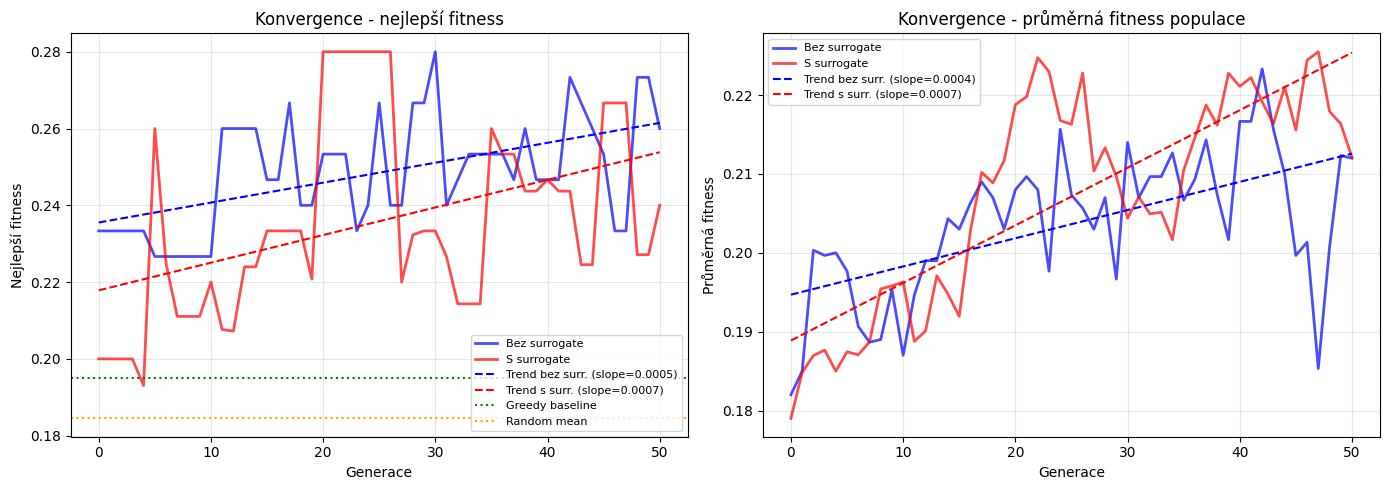

In [61]:
# Porovnání konvergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Best fitness
ax1 = axes[0]
gens = np.arange(len(ea_no_surrogate['fitness_history']))

ax1.plot(gens, ea_no_surrogate['fitness_history'], 'b-', label='Bez surrogate', linewidth=2, alpha=0.7)
ax1.plot(gens, ea_with_surrogate['fitness_history'], 'r-', label='S surrogate', linewidth=2, alpha=0.7)

# Lineární fit pro trend
z1 = np.polyfit(gens, ea_no_surrogate['fitness_history'], 1)
z2 = np.polyfit(gens, ea_with_surrogate['fitness_history'], 1)
ax1.plot(gens, np.poly1d(z1)(gens), 'b--', linewidth=1.5, label=f'Trend bez surr. (slope={z1[0]:.4f})')
ax1.plot(gens, np.poly1d(z2)(gens), 'r--', linewidth=1.5, label=f'Trend s surr. (slope={z2[0]:.4f})')

ax1.axhline(y=baseline_results['greedy']['fitness'], color='g', linestyle=':', label='Greedy baseline')
ax1.axhline(y=baseline_results['random']['mean_fitness'], color='orange', linestyle=':', label='Random mean')
ax1.set_xlabel('Generace')
ax1.set_ylabel('Nejlepší fitness')
ax1.set_title('Konvergence - nejlepší fitness')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Average fitness
ax2 = axes[1]
ax2.plot(gens, ea_no_surrogate['avg_fitness_history'], 'b-', label='Bez surrogate', linewidth=2, alpha=0.7)
ax2.plot(gens, ea_with_surrogate['avg_fitness_history'], 'r-', label='S surrogate', linewidth=2, alpha=0.7)

# Lineární fit pro trend
z3 = np.polyfit(gens, ea_no_surrogate['avg_fitness_history'], 1)
z4 = np.polyfit(gens, ea_with_surrogate['avg_fitness_history'], 1)
ax2.plot(gens, np.poly1d(z3)(gens), 'b--', linewidth=1.5, label=f'Trend bez surr. (slope={z3[0]:.4f})')
ax2.plot(gens, np.poly1d(z4)(gens), 'r--', linewidth=1.5, label=f'Trend s surr. (slope={z4[0]:.4f})')

ax2.set_xlabel('Generace')
ax2.set_ylabel('Průměrná fitness')
ax2.set_title('Konvergence - průměrná fitness populace')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [62]:
# Tabulka efektivity
print("=" * 60)
print("POROVNÁNÍ METOD")
print("=" * 60)

data = [
    ("Random baseline", baseline_results['random']['best_fitness'], 50, "-"),
    ("Greedy baseline", baseline_results['greedy']['fitness'], 1, "-"),
    ("EA bez surrogate", ea_no_surrogate['best_fitness'], ea_no_surrogate['real_evals'], f"{ea_no_surrogate['wall_time']:.1f}s"),
    ("EA s surrogate", ea_with_surrogate['best_fitness'], ea_with_surrogate['real_evals'], f"{ea_with_surrogate['wall_time']:.1f}s"),
]

print(f"{'Metoda':<20} {'Best Fitness':>12} {'Real Evals':>12} {'Čas':>10}")
print("-" * 60)
for name, fitness, evals, time in data:
    print(f"{name:<20} {fitness:>12.4f} {evals:>12} {time:>10}")

print("-" * 60)
if ea_no_surrogate['real_evals'] > 0:
    speedup = ea_no_surrogate['real_evals'] / ea_with_surrogate['real_evals']
    print(f"\nÚspora simulací díky surrogate: {speedup:.1f}x méně")
    
if ea_no_surrogate['wall_time'] > 0:
    time_speedup = ea_no_surrogate['wall_time'] / ea_with_surrogate['wall_time']
    print(f"Časová úspora: {time_speedup:.1f}x rychlejší")

POROVNÁNÍ METOD
Metoda               Best Fitness   Real Evals        Čas
------------------------------------------------------------
Random baseline            0.2400           50          -
Greedy baseline            0.1950            1          -
EA bez surrogate           0.2800         1020     133.4s
EA s surrogate             0.2800          157      32.8s
------------------------------------------------------------

Úspora simulací díky surrogate: 6.5x méně
Časová úspora: 4.1x rychlejší


### 5.3 Vizualizace nejlepších rozložení

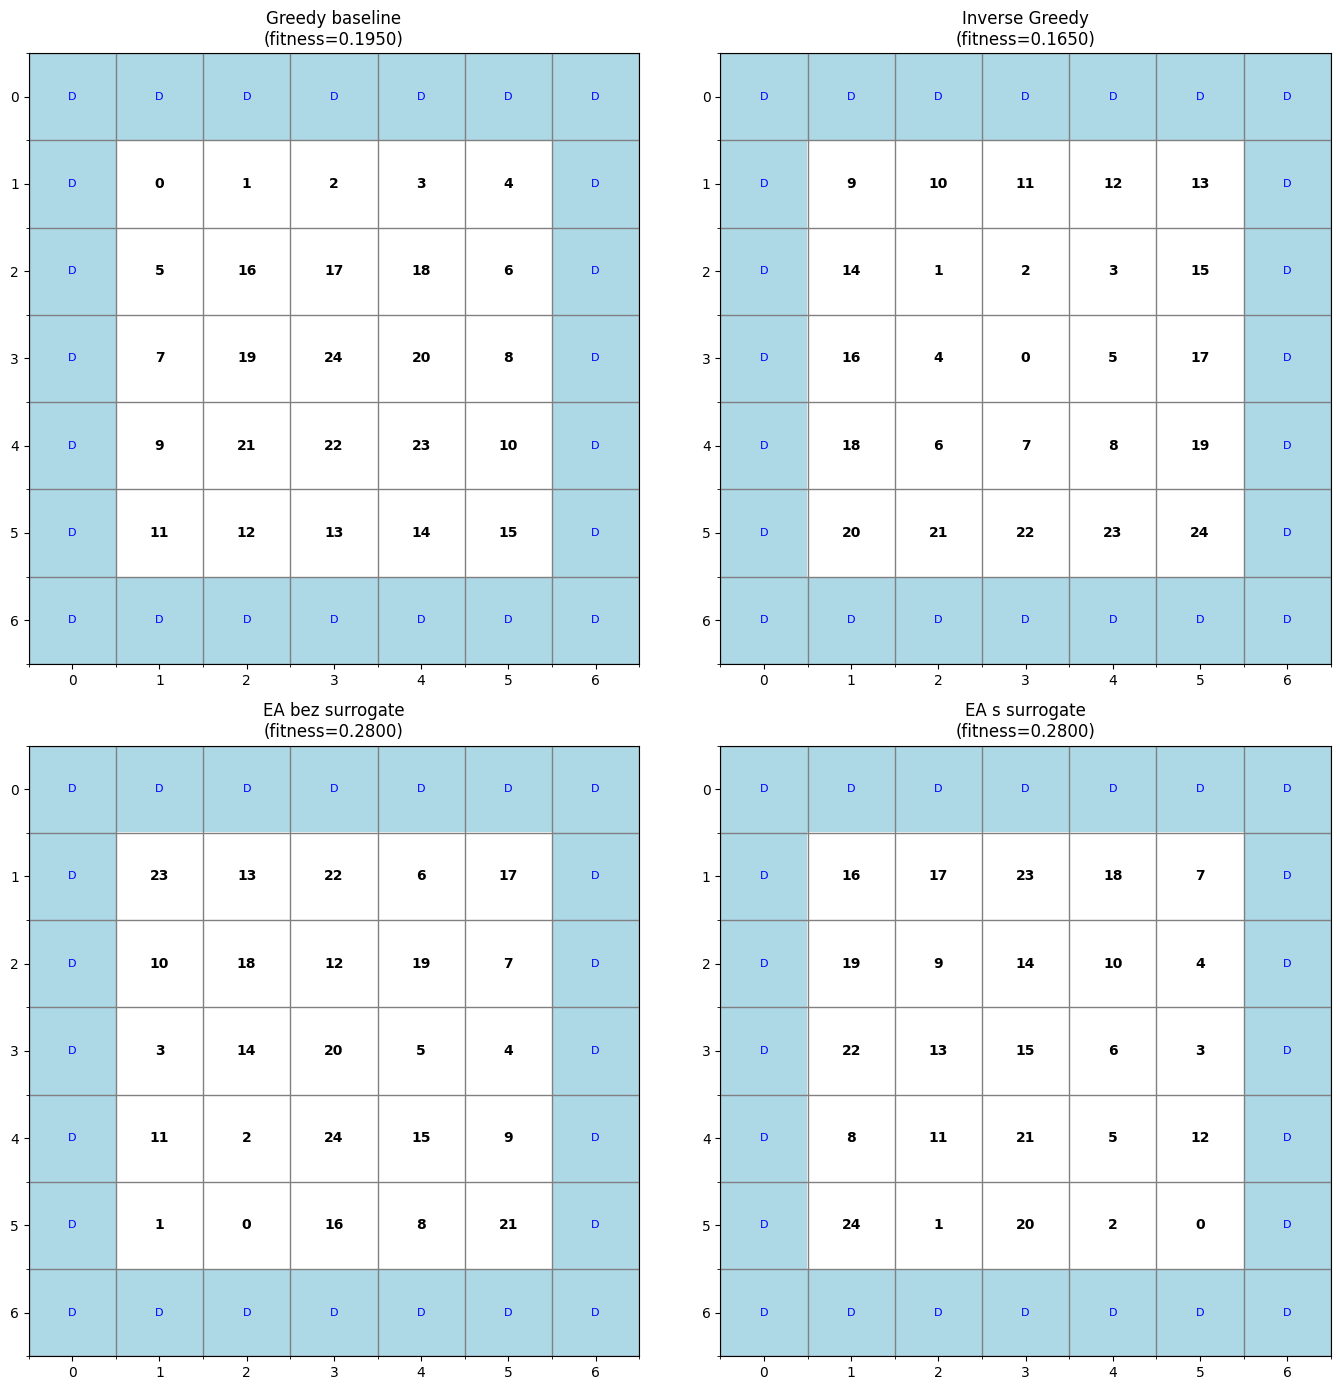

In [63]:
# Vizualizace nejlepších rozložení
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

layouts_to_show = [
    ("Greedy baseline", baseline_results['greedy']['layout'], baseline_results['greedy']['fitness']),
    ("Inverse Greedy", baseline_results['inverse_greedy']['layout'], baseline_results['inverse_greedy']['fitness']),
    ("EA bez surrogate", ea_no_surrogate['best_individual'], ea_no_surrogate['best_fitness']),
    ("EA s surrogate", ea_with_surrogate['best_individual'], ea_with_surrogate['best_fitness']),
]

for ax, (title, layout, fitness) in zip(axes.flatten(), layouts_to_show):
    warehouse.set_layout(layout)
    visualize_warehouse(warehouse, f"{title}\n(fitness={fitness:.4f})", ax)

plt.tight_layout()
plt.show()

### 5.4 Analýza umístění populárního zboží

In [64]:
# Analýza - vzdálenost populárního zboží od okraje
probs = order_gen.get_probabilities()
top_5_goods = np.argsort(probs)[-5:]  # 5 nejpopulárnějších

print("Vzdálenost top 5 nejpopulárnějšího zboží od okraje:")
print("=" * 60)

for title, layout, _ in layouts_to_show:
    warehouse.set_layout(layout)
    distances = []
    for goods_id in top_5_goods:
        pos = warehouse.get_goods_position(goods_id)
        dist = warehouse.distance_to_nearest_edge(pos)
        distances.append(dist)
    avg_dist = np.mean(distances)
    print(f"{title:<25}: průměr = {avg_dist:.2f}, jednotlivě = {distances}")

Vzdálenost top 5 nejpopulárnějšího zboží od okraje:
Greedy baseline          : průměr = 1.00, jednotlivě = [1, 1, 1, 1, 1]
Inverse Greedy           : průměr = 2.20, jednotlivě = [2, 2, 2, 2, 3]
EA bez surrogate         : průměr = 1.20, jednotlivě = [1, 1, 2, 1, 1]
EA s surrogate           : průměr = 1.00, jednotlivě = [1, 1, 1, 1, 1]


## Závěr

Tento notebook demonstroval:

1. **MAPD simulaci** pomocí SAT solveru pro plánování cest
2. **Surrogate modely** pro aproximaci fitness (throughput)
3. **Evoluční optimalizaci** rozložení skladu
4. **Porovnání** evoluce s/bez surrogate modelu

**Klíčové poznatky:**
- Surrogate model výrazně snižuje počet potřebných simulací
- Greedy heuristika (populární zboží blízko okraje) je silný baseline
- Evoluční algoritmus dokáže najít lepší řešení než jednoduché heuristiky